In [2]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [3]:
import fmks
import numpy as np
import numpy.polynomial.legendre as leg
import pymks
import legendre
import matplotlib.pyplot as plt

In [4]:
def draw(x):
    plt.imshow(x)
    plt.colorbar()
    plt.show()

In [5]:
basis = legendre.legendre_basis
print(type(basis))

<class 'function'>


(51, 51)
(51, 51, 4)


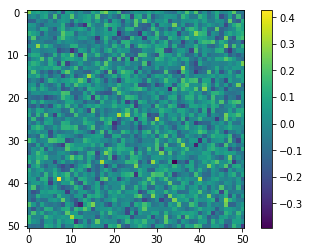

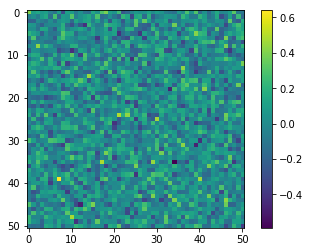

In [12]:
n_local = 4
domain  = (-1, 1)
shape   = (51, 51) 
seed = 101
np.random.seed(seed)
phi = np.random.normal(loc=0.0, scale = 1.0, size=shape)*1.e-1
phi_disc = basis(phi, domain = domain, n_states = n_local)
print(phi.shape)
print(phi_disc.shape)
draw(phi)
draw(phi_disc[:,:,1])

In [ ]:
X_ = basis(X)
FX = _fftn(X_)
Fy = _fftn(y)
Fkernel = np.zeros(FX.shape[1:], dtype=np.complex)
s0 = (slice(None),)

for ijk in np.ndindex(FX.shape[1:-1]):
    s1 = s0
    Fkernel[ijk + s1] = lstsq(FX[s0 + ijk + s1], Fy[s0 + ijk],
                              self.lstsq_rcond)[0]
self._filter = Filter(Fkernel[None], self.basis)